In [1]:
import os
import cv2
import glob
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import plot_model
from PIL import ImageFont, ImageDraw, Image
%matplotlib inline

In [2]:
print(tf.config.list_physical_devices('GPU'))
print(device_lib.list_local_devices())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11306588320417128290
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14407166848
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16784654608370900117
physical_device_desc: "device: 0, name: NVIDIA Tesla T4, pci bus id: 0001:00:00.0, compute capability: 7.5"
]


In [3]:
# DeepFashion Dataset Path
dataset_path = '/data/Deepfashion'
train_path = dataset_path + '/train'
validation_path = dataset_path + '/validation'
test_path = dataset_path + '/test'

In [5]:
img_row, img_col, img_channel = 224, 224, 3
batch_size_train = 64
batch_size_validation = 64
epochs = 10
category_nums = 22
drop_rate = 0.2
learning_rate = 0.001
momentum_num = 0.99

In [6]:
train_csv_path = '/home/azure/passion/AI/Demo/sampling_dataframe/demotrain_small.csv'
train_df = pd.read_csv(train_csv_path)
train_df.head()

,Unnamed: 0,filepath,class_name
0,9500,/data/Deepfashion/train/Blazer/Open-Front_Shaw...,Blazer
1,9501,/data/Deepfashion/train/Blazer/Open-Front_Shaw...,Blazer
2,9502,/data/Deepfashion/train/Blazer/Open-Front_Shaw...,Blazer
3,9503,/data/Deepfashion/train/Blazer/Open-Front_Shaw...,Blazer
4,9504,/data/Deepfashion/train/Blazer/Open-Front_Shaw...,Blazer


In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='class_name',
    target_size=(img_row, img_col),
    batch_size=batch_size_train
)

Found 22846 validated image filenames belonging to 22 classes.


In [8]:
category_nums = {}

print(train_generator.filenames[0].split('/')[4])

for filename in train_generator.filenames:
    class_name = filename.split('/')[4]
    if class_name not in category_nums:
        category_nums[class_name] = 0
    else:
        category_nums[class_name] += 1


# print(category_nums)        
print(sorted(category_nums.items(), key=lambda x: x[1], reverse=True))
print(sum(category_nums.values()))

Blazer
[('Sweater', 1614), ('Dress', 1335), ('Blazer', 1315), ('Skirt', 1292), ('Coat', 1221), ('Cardigan', 1209), ('Tank', 1202), ('Shorts', 1193), ('Blouse', 1150), ('Leggings', 1140), ('Jeans', 1136), ('Shirts', 930), ('Jumpsuit', 926), ('Jacket', 896), ('Romper', 848), ('Cutoffs', 829), ('Hoodie', 818), ('Parka', 818), ('Joggers', 778), ('Top', 768), ('Trunks', 756), ('Tee', 650)]
22824


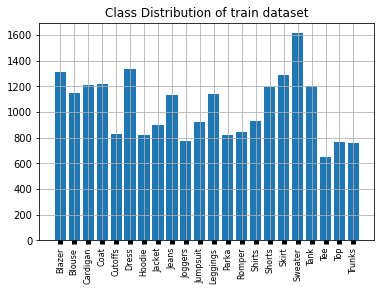

In [9]:
fig, ax = plt.subplots()
plt.bar(list(category_nums.keys()), category_nums.values())
plt.title("Class Distribution of train dataset")
plt.xticks(rotation=90)
plt.tick_params(axis='x', width=5, labelsize=8)
plt.grid(True)
plt.show()

In [10]:
validation_csv_path = '/home/azure/passion/AI/Demo/sampling_dataframe/demovalidation_small.csv'
validation_df = pd.read_csv(validation_csv_path)
validation_df.head()

,Unnamed: 0,filepath,class_name
0,938,/data/Deepfashion/validation/Blazer/Oversized_...,Blazer
1,939,/data/Deepfashion/validation/Blazer/Oversized_...,Blazer
2,940,/data/Deepfashion/validation/Blazer/Oversized_...,Blazer
3,941,/data/Deepfashion/validation/Blazer/Oversized_...,Blazer
4,942,/data/Deepfashion/validation/Blazer/Oversized_...,Blazer


In [11]:
validation_datagen = ImageDataGenerator(
    rescale=1./255
)

validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    x_col='filepath',
    y_col='class_name',
    target_size=(img_row, img_col),
    batch_size=batch_size_validation
)

Found 2188 validated image filenames belonging to 22 classes.


In [12]:
category_nums = {}

print(validation_generator.filenames[0].split('/')[4])

for filename in validation_generator.filenames:
    class_name = filename.split('/')[4]
    if class_name not in category_nums:
        category_nums[class_name] = 0
    else:
        category_nums[class_name] += 1


# print(category_nums)        
print(sorted(category_nums.items(), key=lambda x: x[1], reverse=True))
print(sum(category_nums.values()))

Blazer
[('Shirts', 129), ('Blazer', 101), ('Blouse', 99), ('Cardigan', 99), ('Coat', 99), ('Cutoffs', 99), ('Dress', 99), ('Hoodie', 99), ('Jacket', 99), ('Jeans', 99), ('Joggers', 99), ('Jumpsuit', 99), ('Leggings', 99), ('Romper', 99), ('Shorts', 99), ('Skirt', 99), ('Sweater', 99), ('Tank', 99), ('Tee', 99), ('Top', 99), ('Parka', 97), ('Trunks', 57)]
2166


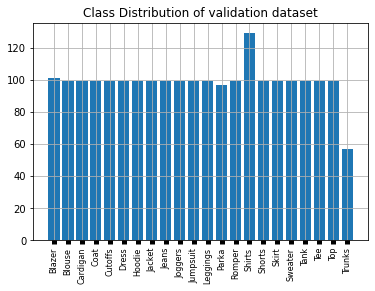

In [13]:
fig, ax = plt.subplots()
plt.bar(list(category_nums.keys()), category_nums.values())
plt.title("Class Distribution of validation dataset")
plt.xticks(rotation=90)
plt.tick_params(axis='x', width=5, labelsize=8)
plt.grid(True)
plt.show()

In [14]:
class_labels_sampling = list(train_generator.class_indices.keys())
print("class labels sampling keys: ", class_labels_sampling)
print("The number of class labels: ", len(class_labels_sampling))
num_imgs_train_sampling = len(train_generator.filenames)
print("The number of train images sampling: ", num_imgs_train_sampling)
num_imgs_validation_sampling = len(validation_generator.filenames)
print("The number of validation images sampling: ", num_imgs_validation_sampling)

class labels sampling keys:  ['Blazer', 'Blouse', 'Cardigan', 'Coat', 'Cutoffs', 'Dress', 'Hoodie', 'Jacket', 'Jeans', 'Joggers', 'Jumpsuit', 'Leggings', 'Parka', 'Romper', 'Shirts', 'Shorts', 'Skirt', 'Sweater', 'Tank', 'Tee', 'Top', 'Trunks']
The number of class labels:  22
The number of train images sampling:  22846
The number of validation images sampling:  2188


In [15]:
# Initialize tne VGG model
vgg_conv = VGG16(
    weights='imagenet', 
    include_top=False, 
    input_shape=(img_row, img_col, img_channel),
    pooling='avg'
)

# Freeze all the layers
for layer in vgg_conv.layers[:]:
    layer.trainable = True

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7facf8314c88> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7facf8180b00> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7facf815d898> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7facf8110c50> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7facf8115d68> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7facf8416e48> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7facf8122550> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7facf81159e8> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7facf812aef0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7facf80b95f8> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7facf80b9f28> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7facf812a

In [16]:
def build_model(vgg_conv, category_nums, drop_rate, learning_rate, momentum_num):
    
    # Create the model
    model = tf.keras.models.Sequential()

    # Add the vgg convolutional base model
    model.add(vgg_conv)

    # Add new layers - Dense, BatchNorm, Activation
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Dropout(drop_rate))
    model.add(Activation('relu'))
    model.add(Dense(22))
    model.add(Activation('softmax'))

    # Compile the model with a SGD and a very slow learning rate
    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )

    return model

In [17]:
model = build_model(vgg_conv, category_nums, drop_rate, learning_rate, momentum_num)

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 22)                11286     
_________________________________________________________________
activation_1 (Activation)    (None, 22)                0

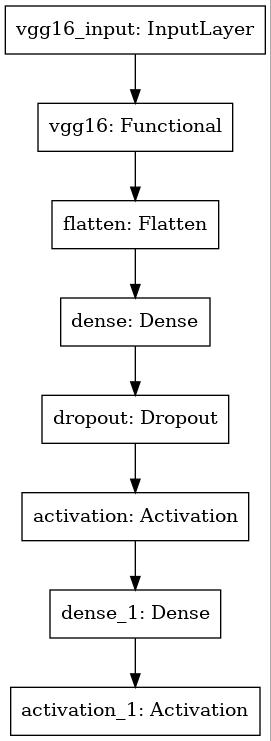

In [19]:
# Show a summary of the model
plot_model(model, to_file='/home/azure/passion/AI/Demo/output/model_summary/small_model.jpg')

In [20]:
def curves(model_histories, epochs):

    acc = model_histories.history['accuracy']
    val_acc = model_histories.history['val_accuracy']
    loss = model_histories.history['loss']
    val_loss = model_histories.history['val_loss']

    # Plot
    plt.plot(range(epochs), acc, 'mo', label='Training accuracy')
    plt.plot(range(epochs), val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.savefig('/home/azure/passion/AI/Demo/output/plot/small_model_accuracy.jpg')

    plt.figure()
    plt.plot(range(epochs), loss, 'mo', label='Training loss')
    plt.plot(range(epochs), val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.savefig('/home/azure/passion/AI/Demo/output/plot/small_model_loss.jpg')
    plt.show()

In [21]:
def callback():
    
    # CSVLogger
    filename = '/home/azure/passion/AI/Demo/output/csv_logger/small_model.csv'
    csv_log = tf.keras.callbacks.CSVLogger(filename, separator=' ', append=False)
    
    # EarlyStopping
#     early_stopping = tf.keras.callbacks.EarlyStopping(
#         monitor='loss', patience=500, verbose=1, mode='min'
#     )
    
    # ModelCheckpoint
    check_point = tf.keras.callbacks.ModelCheckpoint(
        filepath='/home/azure/passion/AI/Demo/output/checkpoint/small_model.ckpt',
        save_best_only=True, save_weights_only=True, monitor='val_loss'
    )
    
    callback_list = [csv_log, check_point]
    return callback_list

In [22]:
callback_list = callback()

In [24]:
def fit_model(model, train_generator, validation_generator, batch_size_train, batch_size_validation, epochs):
    
    history = model.fit(
        train_generator,
        epochs=epochs,
        steps_per_epoch=num_imgs_train_sampling//batch_size_train,
        validation_data=validation_generator,
        validation_steps=num_imgs_validation_sampling//batch_size_validation,
        workers=0,
        verbose=1,
        callbacks=callback_list
    )

    score = model.evaluate(
        validation_generator,
        verbose=1
    )

    return model, history, score

In [25]:
model, history, score = fit_model(model, train_generator, validation_generator, batch_size_train, batch_size_validation, epochs)

# Learning curves
curves(history, epochs)
print('Validation Accuracy:{} \nValidation Loss:{}'.format(score[1] ,score[0]))

# Model Save
model.save('/home/azure/passion/AI/Demo/output/small_model.h5')

Epoch 1/10
356/356 [==============================] - 350s 918ms/step - loss: 3.1198 - accuracy: 0.0659 - val_loss: 3.1225 - val_accuracy: 0.0666
Epoch 2/10
356/356 [==============================] - 310s 871ms/step - loss: 2.7828 - accuracy: 0.1460 - val_loss: 2.4517 - val_accuracy: 0.2293
Epoch 3/10
356/356 [==============================] - 313s 879ms/step - loss: 2.1015 - accuracy: 0.3252 - val_loss: 2.2256 - val_accuracy: 0.2969
Epoch 4/10
356/356 [==============================] - 316s 887ms/step - loss: 1.6580 - accuracy: 0.4554 - val_loss: 2.2803 - val_accuracy: 0.3585
Epoch 5/10
356/356 [==============================] - 315s 886ms/step - loss: 1.3716 - accuracy: 0.5524 - val_loss: 2.4732 - val_accuracy: 0.3585
Epoch 6/10
356/356 [==============================] - 316s 888ms/step - loss: 1.1634 - accuracy: 0.6159 - val_loss: 2.7507 - val_accuracy: 0.3957
Epoch 7/10
356/356 [==============================] - 316s 887ms/step - loss: 1.0111 - accuracy: 0.6596 - val_loss: 3.0086 -

KeyboardInterrupt: 